# Recommendation by Character images

#### ToDo

- [x] Preparations
    - [x] data retrieval
    - [x] convert images to black and white
    - [x] set transformations (`ToTensor()`, `RandomCrop()`)
    - [x] create Dataset
    - [x] create Dataloader
- [x] Representation learning: try with few images
    - [x] define encoder
    - [x] define decoder
    - [x] training codes 
    - [x] training loss visualization
    - [x] validation codes
    - [x] wrap training and validation codes into class
    - [x] create embedding
    - [x] try saving the best encoder model, decoder model, and embedding into files
- [ ] Similarity calculation
    - [x] build most basic similarity search -> query character and it pulls out similar characters
    - [ ] convert character-based representation to title-based representation (sum for each title? average?)
- [ ] Recommendation
    - [ ] recommender function
- [ ] Full data learning ~ recommendation
    - [ ] train with larger data
    - [ ] create and save representation data

#### Other ToDo
- [x] Trouble shooting
    - [x] Fixing "Training loss not going down" problem
        - Problem: Training loss goes down sometimes, but sometimes it doesn't go down from ~0.4
        - [x] preprocessing -> Changed from RandomCrop -> CenterCrop, Normalize
        - [x] Training loss at ~0.4 and not going down -> Model layer -> last layer to be Sigmoid and NOT ReLU for both
        - CenterCrop could really be the reason. After all the improvements, I put back the RandomCrop, and the "training loss not going down" problem happened again
- [ ] Improvements to make
    - [ ] Show the image examples in "tiles"
    - [ ] NN function
    - [ ] Param tuning
        - [x] data size (100 to 500)
        - [ ] learning_rate (0.005, 0.01, 0.05, 0.1) -> 0.005 looks good so far
        - [ ] batch_size(16, 32, 64, 128) -> 16 looks good so far

#### Notes
1. Make training data stratified (certain proportion for each author)
2. Don’t use RGB, but black&white (single scalar value to represent 1 pixel)
3. Padding needs to be flexible
4. not sure about augmentation, but random clipping might work

#### References
- Autoencoder (https://medium.com/pytorch/image-similarity-search-in-pytorch-1a744cf3469)


In [336]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

---
## Data retrieval
---

In [2]:
# # 20p -> 100 titles -> 2111 character images
# # 200p -> 6231 titles -> 39939 images

# df_charas = pd.read_csv("../assets/characters_200p.csv")
# display(df_charas.head())
# print(len(df_charas["title_id"].unique()))
# print(len(df_charas["character_id"].unique()))

In [3]:
# # Reduce the data down to first 500 titles
# first_500_titles = df_charas["title_id"].unique()[:500]
# df_charas_reduced = df_charas[df_charas["title_id"].isin(first_500_titles)]
# print(len(df_charas_reduced))
# df_charas_reduced = df_charas_reduced.drop_duplicates(subset="character_image_url")
# print(len(df_charas_reduced))
# print(len(df_charas_reduced["title_id"].unique()))
# print(len(first_500_titles))
# print(len(df_charas_reduced["character_id"].unique()))
# print(len(df_charas_reduced["character_image_url"].unique()))

# # save
# df_charas_reduced.to_csv("../assets/characters_498_titles", index=False)

---
## Image conversion: from RGB to grayscale
---

In [4]:
# get one image
img = Image.open("../assets/character_images/character_images/10138.png").convert("L")
print(img.format, img.size, img.mode)
img.save("../assets/character_images/character_images_grayscale/10138.png")

None (230, 345) L


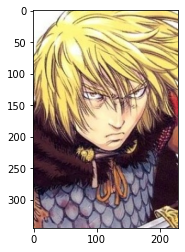

In [5]:
img = Image.open("../assets/character_images/character_images/10138.png")
plt.imshow(np.array(img))

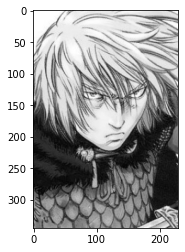

In [6]:
# Confirm grayscale conversion succeeds
img = Image.open("../assets/character_images/character_images_grayscale/10138.png")
plt.imshow(np.array(img), cmap="gray")

In [7]:
# # convert all images to grayscale
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale/"+img)
#     except:
#         print("error at: ", img)

In [8]:
# check if all images have been converted
print(len(os.listdir("../assets/character_images/character_images/")))
print(len(os.listdir("../assets/character_images/character_images_grayscale/")))

7798
7798


---
## Check image sizes
---

In [9]:
# Research possible size patterns first
img_list = os.listdir("../assets/character_images/character_images/")
size_patterns = []
for img in img_list:
    try:
        grey_img = np.array(Image.open("../assets/character_images/character_images_grayscale/"+img))
        size_patterns.append(grey_img.shape) # each shape is (h,w)
        # checking the id of small and large images
        if (grey_img.shape[0] < 80) or (grey_img.shape[0] > 450):
            print(img)
        elif (grey_img.shape[1] < 80):
            print(img)
    except:
        pass

262137.png
183076.png
133532.png
131808.png
183075.png
82573.png
8778.png
120852.png


In [10]:
# Find the max size: each tuple is (height, width)
max_height_img = sorted(size_patterns, key=lambda x: x[0], reverse=True)[0]
max_width_img = sorted(size_patterns, key=lambda x: x[1], reverse=True)[0]
print("max height and max width images: ", max_height_img, max_width_img)

# Find the min size
min_height_img = sorted(size_patterns, key=lambda x: x[0], reverse=False)[0]
min_width_img = sorted(size_patterns, key=lambda x: x[1], reverse=False)[0]
print("min height and min width images: ", min_height_img, min_width_img)

# height can vary from 72 to 491
# width can vary from 78 to 230

# examples of small/large images 
# 262137.png # big (450, 230 ish)
# 183076.png
# 133532.png
# 131808.png
# 183075.png
# 82573.png # (72, 140)
# 8778.png # (97, 78)
# 120852.png

# 
display(pd.Series(size_patterns).value_counts())

max height and max width images:  (491, 230) (326, 230)
min height and min width images:  (72, 140) (97, 78)


(345, 230)    3251
(358, 230)    1005
(350, 225)     943
(360, 230)     297
(344, 230)     221
              ... 
(301, 230)       1
(81, 121)        1
(450, 230)       1
(280, 181)       1
(285, 208)       1
Length: 500, dtype: int64

---
## Image transformation
---

shape before transformation:  (487, 230)
shape after transformation:  torch.Size([1, 200, 200])


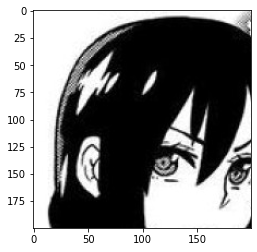

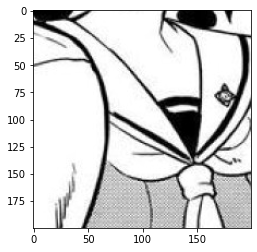

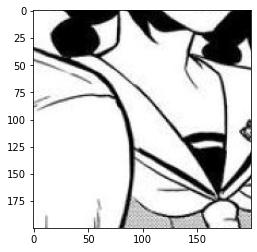

In [11]:
# transform: check cropping process
try_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomCrop(200, pad_if_needed=True)
                                  ])

img = Image.open("../assets/character_images/character_images_grayscale/183076.png")

# check: tensor conversion and addition of channel dimension
img_before = np.array(img)
img_after = try_transform(img)
print("shape before transformation: ", img_before.shape) # [h,w]
print("shape after transformation: ", img_after.size()) # [c,h,w]

# check: if small/large images are cropped ok (padded if img is small)
imgs_after = [try_transform(img) for _ in range(3)]
back_transform = transforms.Compose([transforms.ToPILImage()])
for img in imgs_after:
    pil_img = back_transform(img)
    plt.imshow(np.array(pil_img), cmap="gray")
    plt.show()

---
## Dataset and Dataloader
---

In [410]:
# # quick preparation of trial data
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list[:501]):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale_test/"+img)
#     except:
#         print("error at: ", img)

In [411]:
# check file count
print(len(os.listdir("../assets/character_images/character_images_grayscale_test/")))

500


In [412]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform_steps:
            tensor_img = self.transform_steps(img)

        character_id = self.target_imgs[idx].split(".")[0]
        # first is input to the model, second is input for reconstruction, third is the character_id for future ref
        return tensor_img, tensor_img, character_id

In [413]:
# Define transformations and initialize Dataset
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
manga_dataset = MangaDataset("../assets/character_images/character_images_grayscale_test", transform_steps)

In [414]:
# Set DataLoader

# Split train and data
train_size = int(manga_dataset.__len__() * 0.75)
val_size = int(manga_dataset.__len__() - train_size)
train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# All dataloader
all_data_loader = DataLoader(manga_dataset, batch_size=32)

3
<class 'tuple'>
torch.Size([1, 200, 200])
input batch shape: torch.Size([32, 1, 200, 200])
output batch shape: torch.Size([32, 1, 200, 200])


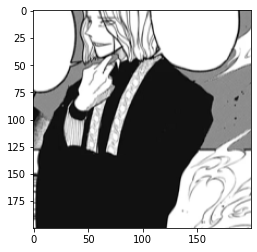

In [415]:
# Check Dataset
img_ex = train_dataset.__getitem__(0)
print(len(img_ex))
print(type(img_ex))
print(img_ex[0].shape)

# Check DataLoader
input_tensor, output_tensor, character_id = next(iter(train_loader))
print(f"input batch shape: {input_tensor.size()}")
print(f"output batch shape: {output_tensor.size()}")
img_ex = input_tensor[0].squeeze()
plt.imshow(img_ex, cmap="gray")
plt.show()

In [416]:
# set the steps as a function
def prep_data(data_path, transform_steps, train_ratio, batch_size):
    manga_dataset = MangaDataset(data_path, transform_steps)
    train_size = int(manga_dataset.__len__() * 0.75)
    val_size = int(manga_dataset.__len__() - train_size)
    train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    all_data_loader = DataLoader(manga_dataset, batch_size=32)
    return train_loader, val_loader, all_data_loader

---
## Autoencoder
---

In [417]:
# Encoder
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        # note on nn.ReLU(inplace=True) -> https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948/4
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.sig5 = nn.Sigmoid()
        self.maxpool5 = nn.MaxPool2d(2)


    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = self.maxpool4(self.relu4(self.conv4(x)))
        x = self.maxpool5(self.sig5(self.conv5(x)))
        
        return x

In [418]:
# Decoder
# keeping the same shape as input -> https://stackoverflow.com/questions/68794161/how-to-solve-dimensions-mismatch-error-in-tensorflow-autoencoder
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        # shaping output: H_out = ((H_in - 1) * str) - (2 * pad) + (dilation * kernel-1) + output_pad + 1
        # just make output (h, w) to be 200,200

        self.deconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2) # (6-1)*2-(2*0)+(1*(2-1)+0+1 = 10-0+1+1 = 12
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, 2, stride=2, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, 2, stride=2, output_padding=1)
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1)
        self.sig5 = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.deconv1(x)) # shape = [32, 128, 12, 12] height is 12, so correct.
        x = self.relu2(self.deconv2(x))
        x = self.relu3(self.deconv3(x))
        x = self.relu4(self.deconv4(x))
        x = self.sig5(self.deconv5(x))

        return x

character_id:  ('138875', '128096', '154177', '82061', '25655', '34016', '207567', '345', '68729', '126031', '88415', '85331', '29244', '22002', '279770', '199025', '43383', '141592', '136221', '22902', '169994', '52883', '150138', '6188', '89355', '954', '18414', '86019', '7000', '157951', '64769', '38816')
torch.Size([32, 1, 200, 200])
encoder output shape:  torch.Size([32, 256, 6, 6])
decoder output shape:  torch.Size([32, 1, 200, 200])


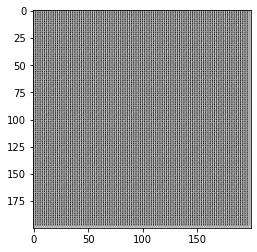

In [419]:
# test encoder
encoder = Encoder()
encoder.train()
input_tensor, output_tensor, character_id = next(iter(train_loader))
print("character_id: ", character_id)
print(input_tensor.shape)
encoder_output = encoder(input_tensor)
print("encoder output shape: ", encoder_output.shape) # [batch_size, channel, h, w]

# test decoder
decoder = Decoder()
decoder.train()
decoder_output = decoder(encoder_output)
print("decoder output shape: ", decoder_output.shape) # [batch_size, channel, h, w]

# show the decoder output -> just shows patterns since it's the very first layer
img_ex = decoder_output[0].detach().numpy().squeeze()
plt.imshow(img_ex, cmap="gray")
plt.show()

---
## Training and Validation
---

In [420]:
# initialize again, set to train mode, send models to gpu
encoder = Encoder()
decoder = Decoder()
encoder.train()
decoder.train()
device = "cuda"
encoder.to(device)
decoder.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(ae_params, lr=0.005)

# train
losses = []

for epoch in tqdm(range(10)):
    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        # forward
        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = criterion(dec_output, target_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / counter
    losses.append(avg_loss)

100%|██████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


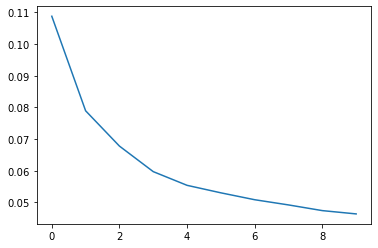

In [421]:
# quick plot of training losses
plt.plot(losses)

In [422]:
encoder.eval()
decoder.eval()

# validate
val_losses = []

for epoch in tqdm(range(10)):
    with torch.no_grad():
        running_loss = 0.0
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)

            # calculate loss
            loss = criterion(dec_output, target_img)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        val_losses.append(avg_loss)

100%|██████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.73it/s]


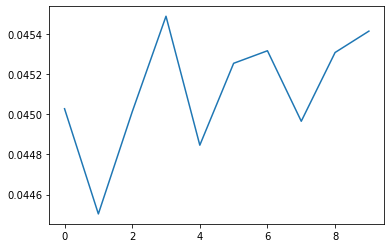

In [423]:
# quick plot of training losses
plt.plot(val_losses)

In [424]:
# Putting training and validation into methods
def train_step(encoder, decoder, train_loader, criterion, optimizer, device):
    encoder.train()
    decoder.train()

    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = criterion(dec_output, target_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / counter
    return avg_loss


def val_step(encoder, decoder, val_loader, criterion, device):
    encoder.eval()
    decoder.eval()

    running_loss = 0.0
    with torch.no_grad():
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)

            # calculate loss
            loss = criterion(dec_output, target_img)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        return avg_loss

In [428]:
# train and validate to check that the methods work

# redo the settings all again

# set data
# better with batch_size=64 rather than 32 (32 can end up with training curve not going down)
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=16)

# prep model
encoder = Encoder()
decoder = Decoder()
device = "cuda"
encoder.to(device)
decoder.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(ae_params, lr=0.005)

# check that it works
EPOCHS = 100
train_losses = []
val_losses = []
min_loss = 1e5

for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss = train_step(encoder, decoder, train_loader, criterion, optimizer, device=device)
    train_losses.append(train_loss)
    # print(f"Epochs = {epoch}, Training Loss : {train_loss}")

    val_loss = val_step(encoder, decoder, val_loader, criterion, device=device)
    val_losses.append(val_loss)
    # print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

    # Save the best model
    if val_loss < min_loss:
        best_encoder = copy.deepcopy(encoder)
        best_decoder = copy.deepcopy(decoder)
        torch.save(best_encoder.state_dict(), "../assets/character_images/models_and_embeddings/encoder_model.pt")
        torch.save(best_decoder.state_dict(), "../assets/character_images/models_and_embeddings/decoder_model.pt")
        min_loss = val_loss
        

100%|████████████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.89s/it]


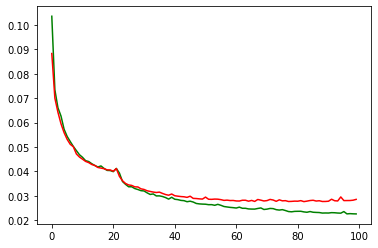

In [429]:
# plot training & validation losses
plt.plot(train_losses,"g", val_losses, "r")
plt.show()

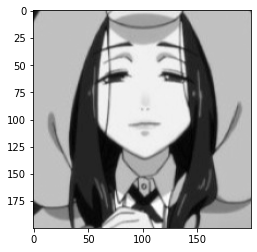

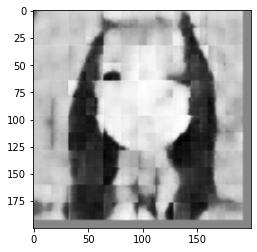

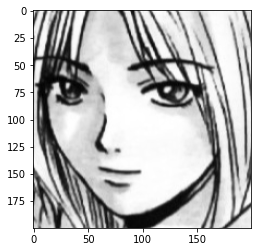

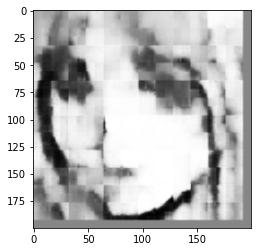

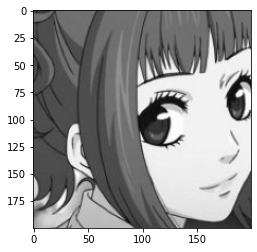

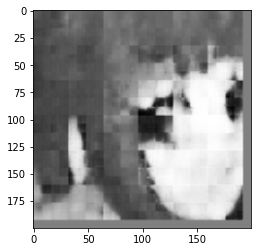

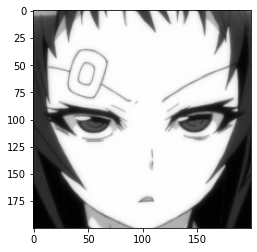

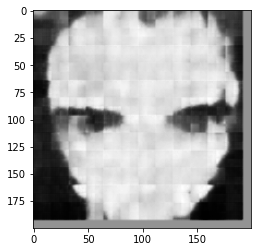

In [430]:
# show what the model learned -> look how validation images are now represented by the decoder
# if the model learned the images well, they should look similar to each other

# Note: 
# when training loss doesn't go down (10 epochs, ~0.4 loss at minimum) -> dec_output is all BLACK and can't see anything
# when training loss goes down (50 epochs, ~0.04) -> dec_output is blurry but somewhat similar to the input

encoder.eval()
decoder.eval()
with torch.no_grad():
    for train_img, target_img, _ in val_loader:
        
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)
        
        # show only the first image of each batch (output original and decoder output images for comparison)
        for t_img, d_img in zip(train_img[0], dec_output[0]):
            plt.imshow(t_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()
            plt.imshow(d_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()

---
## Create embedding
---

In [431]:
# create embedding

encoder.eval()
embedding = torch.zeros((1, 256, 6, 6))
character_ids = []
with torch.no_grad():
    for train_img, target_img, character_id in all_data_loader:
        train_img = train_img.to(device)
        enc_output = encoder(train_img).cpu()
        embedding = torch.cat((embedding, enc_output), 0)
        character_ids.append(character_id)

In [432]:
# Convert to numpy and save
character_ids = list(itertools.chain.from_iterable(character_ids))
np_character_ids = np.array(character_ids)
embedding = embedding[1:, :, :, :]
print("len of character_ids: ", len(character_ids))
print("shape of embedding: ", embedding.shape)
np_embedding = embedding.cpu().detach().numpy()
num_images = np_embedding.shape[0]

# Save the embeddings
flattened_embedding = np_embedding.reshape((num_images, -1))
print("shape of flattened embedding: ", flattened_embedding.shape)
np.save("../assets/character_images/models_and_embeddings/image_embedding.npy", flattened_embedding)
np.save("../assets/character_images/models_and_embeddings/image_embedding_character_ids.npy", np_character_ids)

len of character_ids:  500
shape of embedding:  torch.Size([500, 256, 6, 6])
shape of flattened embedding:  (500, 9216)


---
## Similarity calculation
---

### Interpretation
- Results seem convincing, but it doesn't really see the "drawing style" of the images
- It pulls out images that are similarly colored or with similar contrast
- It's hard to take the angle of the faces into account too

In [436]:
embedding_flat_np = np.load("../assets/character_images/models_and_embeddings/image_embedding.npy") 
embedding_ids = np.load("../assets/character_images/models_and_embeddings/image_embedding_character_ids.npy") 
print(embedding_flat_np.shape)
print(embedding_ids.shape)
print(embedding_ids[:20])

(500, 9216)
(500,)
['133196' '46494' '234' '123008' '86083' '128404' '23796' '207020'
 '137304' '154177' '52331' '15531' '86683' '32640' '74653' '217273'
 '195986' '131519' '130789' '206535']


In [437]:
class ImageSearch:
    def __init__(self, query_path):
        self.embedding_flat_np = np.load("../assets/character_images/models_and_embeddings/image_embedding.npy") 
        self.embedding_ids = np.load("../assets/character_images/models_and_embeddings/image_embedding_character_ids.npy") 
        self.df_charas = pd.read_csv("../assets/characters_200p.csv")
        self.query_path = query_path

    def search_similar_characters(self, query_character_id, top_n):

        # similarity matrix df
        df_sim_mat = pd.DataFrame(cosine_similarity(self.embedding_flat_np))
        df_sim_mat.index = self.embedding_ids
        df_sim_mat.columns = self.embedding_ids

        # querying character
        display(self.df_charas[self.df_charas["character_id"]==query_character_id])
        img = Image.open(self.query_path + str(query_character_id) + ".png")
        plt.imshow(np.array(img), cmap="gray")
        plt.show()

        # get similar character
        df = df_sim_mat[str(query_character_id)].sort_values(ascending=False)
        df_top = df[1:top_n+1]
        top_ids = df_top.index
        print(top_ids)
        for id in top_ids:
            img = Image.open(self.query_path + id + ".png")
            plt.imshow(np.array(img), cmap="gray")
            plt.show()


,title_id,title_english,title_romaji,character_id,character_name,character_image_url
7276,98148,Black Torch,BLACK TORCH,137304,Jirou Azuma,https://s4.anilist.co/file/anilistcdn/characte...


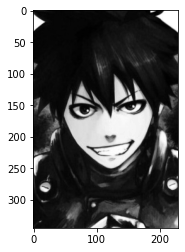

Index(['3762', '279770', '85297'], dtype='object')


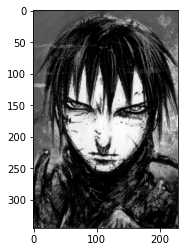

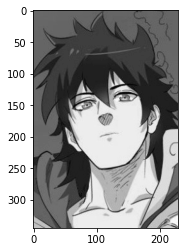

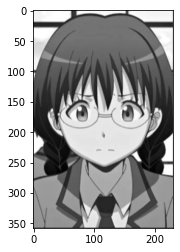

In [442]:
im_search = ImageSearch("../assets/character_images/character_images_grayscale/")
im_search.search_similar_characters(query_character_id=137304, top_n=3)